# Job characteristics analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read logs

In [3]:
job_chars = pd.read_parquet('job_chars.parquet')

In [4]:
job_chars

,Batch_class,Submission_date,Waited,Start_date,Duration,Nodes,CPU,Memory,delta_CPU,delta_Memory
000030ecd19c9c04,feque,2020-02-18 11:14:38+01:00,29.916667,2020-02-18 11:44:33+01:00,1.450000,1.0,0.168851,0.31349,0.000000,0.000000
00020fcd04947084,clexpres,2020-05-30 11:50:05+02:00,5.383333,2020-05-30 11:55:28+02:00,4.700000,2.0,31.315993,2.02000,0.000000,0.000000
00027e89035bec8d,clmedium,2020-03-25 21:22:02+01:00,38.783333,2020-03-25 22:00:49+01:00,1.283333,1.0,21.721169,131.76000,0.000000,0.000000
0003a37a7a8562f1,clexpres,2020-03-06 11:52:11+01:00,70.450000,NaT,NaN,1.0,NaN,NaN,NaN,NaN
00040700e386e4c9,clfo2,NaT,NaN,2020-02-07 08:27:49+01:00,33.716667,8.0,23.732037,1.42000,9.111494,0.066250
...,...,...,...,...,...,...,...,...,...,...
fff9d98fe020471f,clmedium,2020-02-29 14:20:38+01:00,1187.316667,2020-03-01 10:07:57+01:00,104.850000,4.0,31.681539,2.07000,5.921512,0.110000
fffabf82e38ce12d,clmedium,2020-03-11 14:13:06+01:00,1763.016667,2020-03-12 19:36:07+01:00,1802.366667,1.0,31.920809,1.90000,0.151690,0.035250
fffb2d67011101c5,clmedium,NaT,NaN,2020-03-18 20:23:17+01:00,117.633333,1.0,1.099404,1.46000,0.964377,1.191159
fffbfaccf8c9fbf4,clexpres,NaT,NaN,2020-03-27 15:05:44+01:00,5.033333,1.0,0.190265,0.11484,0.000000,0.000000


## Quick overview

### Jobs with undetected processing time

In [10]:
undetected_processing_time_jobs = job_chars['Duration'].isna()
print(undetected_processing_time_jobs.sum()/job_chars.shape[0]*100, '%')

44.99086183877951 %


### Jobs both queued and processed

In [11]:
queued_and_processed_jobs = job_chars['Waited'].notna() & job_chars['Duration'].notna()
print(queued_and_processed_jobs.sum()/job_chars.shape[0]*100, '%')

29.06842603274184 %


### Jobs with undetected queue times

In [12]:
undetected_waiting_time_jobs = job_chars['Waited'].isna()
print(undetected_waiting_time_jobs.sum()/job_chars.shape[0]*100, '%')

25.94071212847866 %


### Category integrity check

In [8]:
all_jobs = undetected_processing_time_jobs | queued_and_processed_jobs | undetected_waiting_time_jobs

In [9]:
print(all_jobs.sum()/job_chars.shape[0]*100, '%')

100.0 %


## Statistical analysis
The goal of this analysis is to find out about...

### Batch class

In [13]:
def target_quantity(job_logs_column, boolean_mask):
    if boolean_mask is None:
        return job_logs_column.value_counts()/job_logs_column.size
    else:
        return job_logs_column[boolean_mask].value_counts()/boolean_mask.sum()

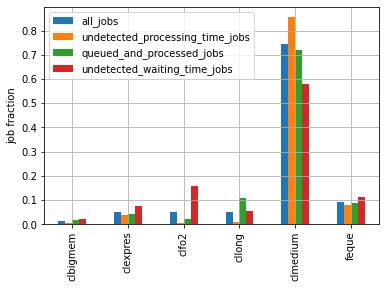

In [14]:
target = pd.DataFrame({
    'all_jobs': target_quantity(job_chars['Batch_class'], None),
    'undetected_processing_time_jobs': target_quantity(job_chars['Batch_class'], undetected_processing_time_jobs),
    'queued_and_processed_jobs': target_quantity(job_chars['Batch_class'], queued_and_processed_jobs),
    'undetected_waiting_time_jobs': target_quantity(job_chars['Batch_class'], undetected_waiting_time_jobs),
             })
target.plot.bar()
plt.ylabel('job fraction'); plt.grid()

In [15]:
100*target['all_jobs']

clbigmem     1.390815
clexpres     5.039599
clfo2        5.003305
cllong       5.112186
clmedium    74.326304
feque        9.127792
Name: all_jobs, dtype: float64

### Submission hour and weekday
For the jobs with undetected waiting time, assume the start date as submission date.

In [16]:
temp_job_chars = job_chars.copy()
temp_job_chars['Submission_date'].fillna(temp_job_chars['Start_date'], inplace=True)

In [17]:
def target_quantity(job_logs_column, boolean_mask):
    if boolean_mask is None:
        return job_logs_column.dt.hour.value_counts().sort_index()/job_logs_column.size
    else:
        return job_logs_column[boolean_mask].dt.hour.value_counts().sort_index()/boolean_mask.sum()

all_jobs                           0.041667
undetected_processing_time_jobs    0.041667
queued_and_processed_jobs          0.041667
undetected_waiting_time_jobs       0.041667
dtype: float64


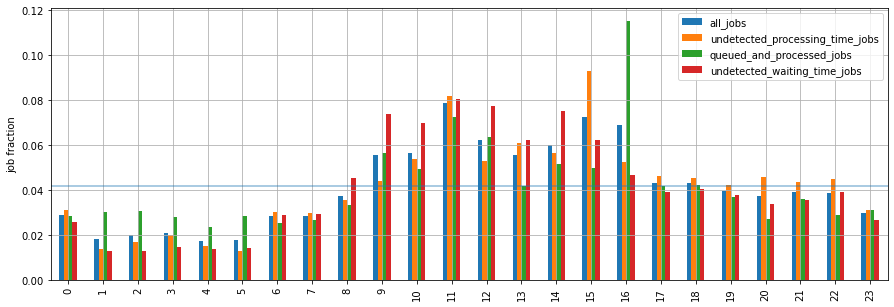

In [18]:
target = pd.DataFrame({
    'all_jobs': target_quantity(temp_job_chars['Submission_date'], None),
    'undetected_processing_time_jobs': target_quantity(temp_job_chars['Submission_date'], undetected_processing_time_jobs),
    'queued_and_processed_jobs': target_quantity(temp_job_chars['Submission_date'], queued_and_processed_jobs),
    'undetected_waiting_time_jobs': target_quantity(temp_job_chars['Submission_date'], undetected_waiting_time_jobs)
             })

print(target.mean())

ax = target.plot.bar(figsize=(15,5))
ax.axhline(y=target.mean().to_numpy()[0], color='tab:blue', alpha=0.5)

plt.ylabel('job fraction'); plt.grid()

In [19]:
def target_quantity(job_logs_column, boolean_mask):
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    if boolean_mask is None:
        return (job_logs_column.dt.day_name().value_counts()/job_logs_column.size).reindex(cats)
    else:
        return (job_logs_column[boolean_mask].dt.day_name().value_counts()/boolean_mask.sum()).reindex(cats)

all_jobs                           0.142857
undetected_processing_time_jobs    0.142857
queued_and_processed_jobs          0.142857
undetected_waiting_time_jobs       0.142857
dtype: float64


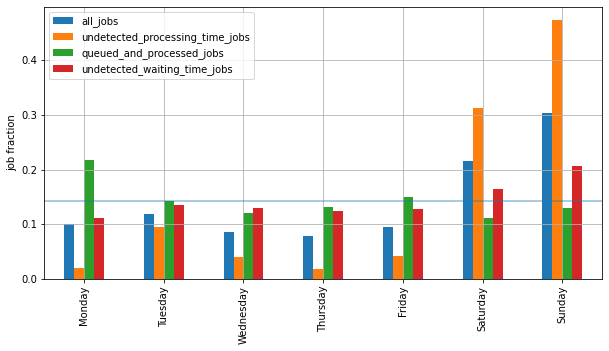

In [20]:
target = pd.DataFrame({
    'all_jobs': target_quantity(temp_job_chars['Submission_date'], None),
    'undetected_processing_time_jobs': target_quantity(temp_job_chars['Submission_date'], undetected_processing_time_jobs),
    'queued_and_processed_jobs': target_quantity(temp_job_chars['Submission_date'], queued_and_processed_jobs),
    'undetected_waiting_time_jobs': target_quantity(temp_job_chars['Submission_date'], undetected_waiting_time_jobs)
             })
ax = target.plot.bar(figsize=(10,5))
print(target.mean())
ax.axhline(y=target.mean().to_numpy()[0], color='tab:blue', alpha=0.5)

plt.ylabel('job fraction'); plt.grid()

### Start hour and weekday

In [21]:
def target_quantity(job_logs_column, boolean_mask):
    if boolean_mask is None:
        return job_logs_column.dt.hour.value_counts().sort_index()/job_logs_column.size
    else:
        return job_logs_column[boolean_mask].dt.hour.value_counts().sort_index()/boolean_mask.sum()

all_jobs                        0.041667
queued_and_processed_jobs       0.041667
undetected_waiting_time_jobs    0.041667
dtype: float64


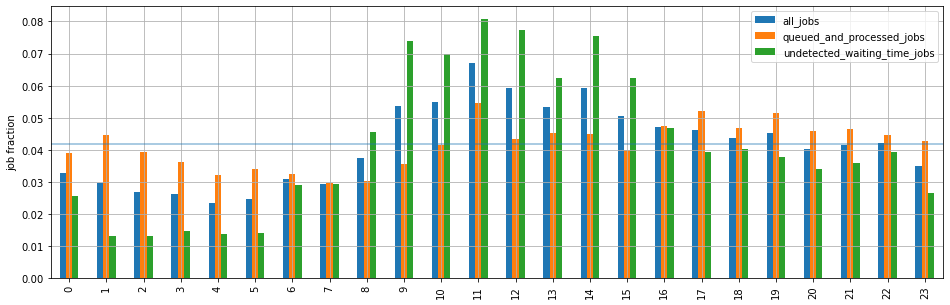

In [22]:
target = pd.DataFrame({
    'all_jobs': target_quantity(temp_job_chars['Start_date'], queued_and_processed_jobs | undetected_waiting_time_jobs),
    'queued_and_processed_jobs': target_quantity(temp_job_chars['Start_date'], queued_and_processed_jobs),
    'undetected_waiting_time_jobs': target_quantity(temp_job_chars['Start_date'], undetected_waiting_time_jobs)
             })
ax = target.plot.bar(figsize=(16,5))
print(target.mean())
ax.axhline(y=target.mean().to_numpy()[0], color='tab:blue', alpha=0.5)
plt.ylabel('job fraction'); plt.grid()

In [23]:
def target_quantity(job_logs_column, boolean_mask):
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    if boolean_mask is None:
        return (job_logs_column.dt.day_name().value_counts()/job_logs_column.size).reindex(cats)
    else:
        return (job_logs_column[boolean_mask].dt.day_name().value_counts()/boolean_mask.sum()).reindex(cats)

all_jobs                        0.078584
queued_and_processed_jobs       0.142857
undetected_waiting_time_jobs    0.142857
dtype: float64


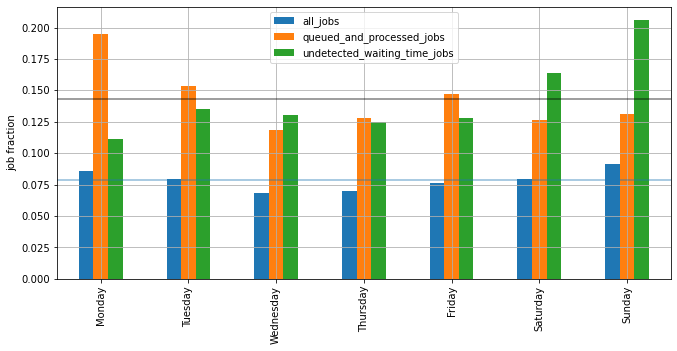

In [24]:
target = pd.DataFrame({
    'all_jobs': target_quantity(temp_job_chars['Start_date'], None),
    'queued_and_processed_jobs': target_quantity(temp_job_chars['Start_date'], queued_and_processed_jobs),
    'undetected_waiting_time_jobs': target_quantity(temp_job_chars['Start_date'], undetected_waiting_time_jobs)
             })
ax = target.plot.bar(figsize=(11,5))
print(target.mean())
ax.axhline(y=target.mean().to_numpy().min(), color='tab:blue', alpha=0.5)
ax.axhline(y=target.mean().to_numpy().max(), color='k', alpha=0.5)
plt.ylabel('job fraction'); plt.grid()

### Duration

Text(0.5, 0, 'Duration in minutes')

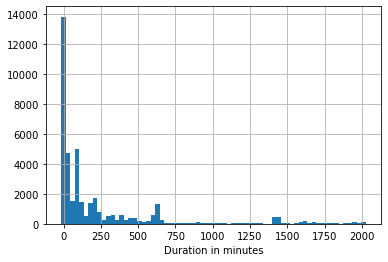

In [25]:
target_jobs = job_chars
target_jobs['Duration'].hist(bins=np.arange(-15,target_jobs['Duration'].quantile(0.95),30))
plt.xlabel('Duration in minutes')

Text(0.5, 0, 'Duration in minutes')

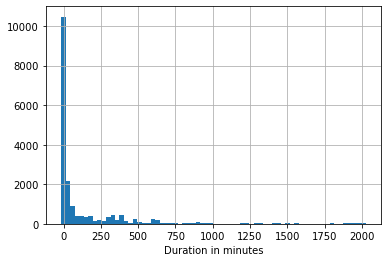

In [26]:
target_jobs = job_chars[undetected_waiting_time_jobs]
target_jobs['Duration'].hist(bins=np.arange(-15,target_jobs['Duration'].quantile(0.95),30))
plt.xlabel('Duration in minutes')

Text(0.5, 0, 'Duration in minutes')

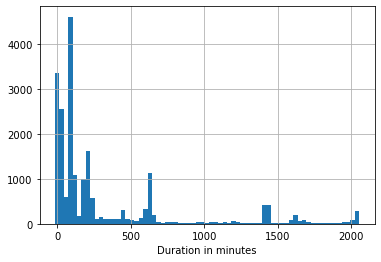

In [27]:
target_jobs = job_chars[queued_and_processed_jobs]
target_jobs['Duration'].hist(bins=np.arange(-15,target_jobs['Duration'].quantile(0.95),30))
plt.xlabel('Duration in minutes')

### Nodes
Most jobs are single-node jobs, followed by a few four-node jobs.

Text(0.5, 1.0, 'undetected_waiting_time_jobs')

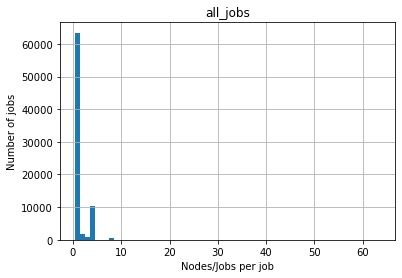

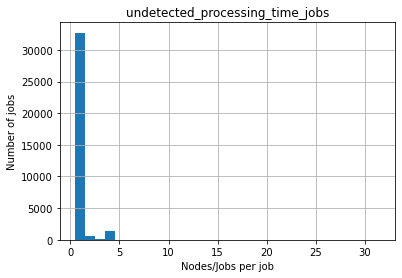

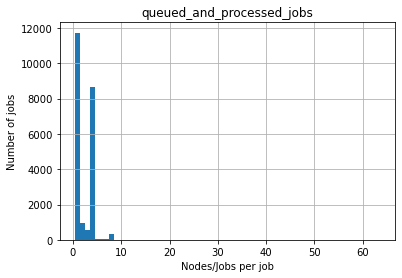

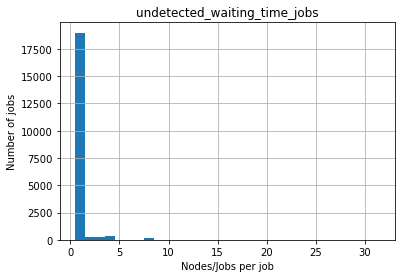

In [28]:
plt.figure()
target_jobs = job_chars
target_jobs['Nodes'].hist(bins=np.arange(0.5,target_jobs['Nodes'].max(),1))
plt.xlabel('Nodes/Jobs per job'); plt.ylabel('Number of jobs')
plt.title('all_jobs')

plt.figure()
target_jobs = job_chars[undetected_processing_time_jobs]
target_jobs['Nodes'].hist(bins=np.arange(0.5,target_jobs['Nodes'].max(),1))
plt.xlabel('Nodes/Jobs per job'); plt.ylabel('Number of jobs')
plt.title('undetected_processing_time_jobs')

plt.figure()
target_jobs = job_chars[queued_and_processed_jobs]
target_jobs['Nodes'].hist(bins=np.arange(0.5,target_jobs['Nodes'].max(),1))
plt.xlabel('Nodes/Jobs per job'); plt.ylabel('Number of jobs')
plt.title('queued_and_processed_jobs')

plt.figure()
target_jobs = job_chars[undetected_waiting_time_jobs]
target_jobs['Nodes'].hist(bins=np.arange(0.5,target_jobs['Nodes'].max(),1))
plt.xlabel('Nodes/Jobs per job'); plt.ylabel('Number of jobs')
plt.title('undetected_waiting_time_jobs')

### CPU usage

Text(0.5, 1.0, 'undetected_waiting_time_jobs')

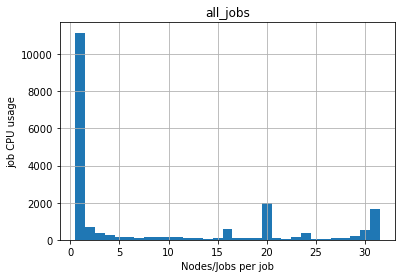

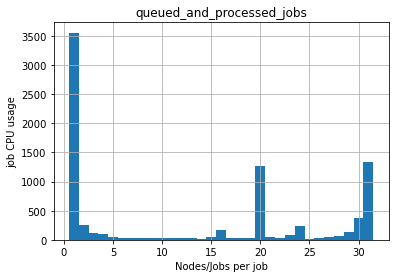

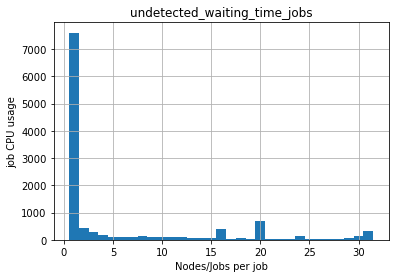

In [29]:
plt.figure()
target_jobs = job_chars
target_jobs['CPU'].hist(bins=np.arange(0.5,target_jobs['CPU'].quantile(0.95),1))
plt.xlabel('Nodes/Jobs per job'); plt.ylabel('job CPU usage')
plt.title('all_jobs')

plt.figure()
target_jobs = job_chars[queued_and_processed_jobs]
target_jobs['CPU'].hist(bins=np.arange(0.5,target_jobs['CPU'].quantile(0.95),1))
plt.xlabel('Nodes/Jobs per job'); plt.ylabel('job CPU usage')
plt.title('queued_and_processed_jobs')

plt.figure()
target_jobs = job_chars[undetected_waiting_time_jobs]
target_jobs['CPU'].hist(bins=np.arange(0.5,target_jobs['CPU'].quantile(0.95),1))
plt.xlabel('Nodes/Jobs per job'); plt.ylabel('job CPU usage')
plt.title('undetected_waiting_time_jobs')

### Memory usage

Text(0.5, 1.0, 'undetected_waiting_time_jobs')

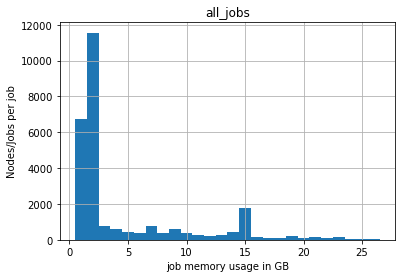

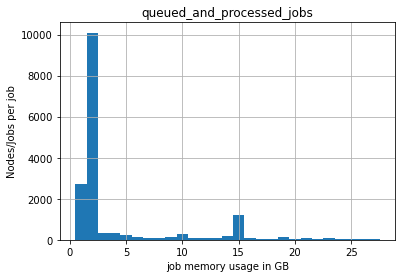

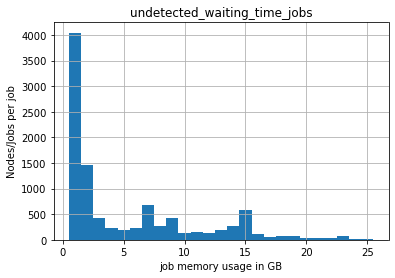

In [30]:
plt.figure()
target_jobs = job_chars
target_jobs['Memory'].hist(bins=np.arange(0.5,target_jobs['Memory'].quantile(0.95),1))
plt.ylabel('Nodes/Jobs per job'); plt.xlabel('job memory usage in GB')
plt.title('all_jobs')

plt.figure()
target_jobs = job_chars[queued_and_processed_jobs]
target_jobs['Memory'].hist(bins=np.arange(0.5,target_jobs['Memory'].quantile(0.95),1))
plt.ylabel('Nodes/Jobs per job'); plt.xlabel('job memory usage in GB')
plt.title('queued_and_processed_jobs')

plt.figure()
target_jobs = job_chars[undetected_waiting_time_jobs]
target_jobs['Memory'].hist(bins=np.arange(0.5,target_jobs['Memory'].quantile(0.95),1))
plt.ylabel('Nodes/Jobs per job'); plt.xlabel('job memory usage in GB')
plt.title('undetected_waiting_time_jobs')

### Waiting times
Analysis makes only sense for jobs that either were both queued and processed, and those that never ran.

#### Jobs with undetected processing times
Most of these jobs were only queued for shorter than logging period times, hence the zero minutes waiting time estimates. Larger waiting times are simply multiples of the log period. These jobs could either have had run times smaller than the logging period (so that we missed them running), or they indeed never ran because e.g. they were manually deleted by the user.

Text(0.5, 0, 'Waiting time in minutes')

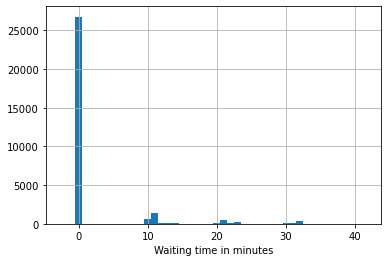

In [69]:
target_jobs = job_chars[undetected_processing_time_jobs]
target_jobs['Waited'].hist(bins=np.arange(-2.5,target_jobs['Waited'].quantile(0.95),1))
plt.xlabel('Waiting time in minutes')

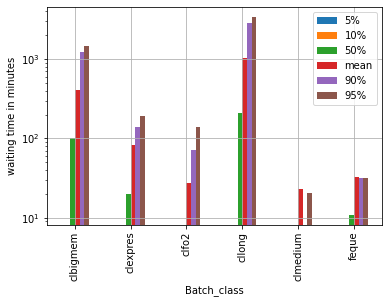

In [70]:
pd.DataFrame({
    '5%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.05),
    '10%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.10),
    '50%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.50),
    'mean': target_jobs.groupby('Batch_class')['Waited'].mean(),
    '90%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.90),
    '95%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.95),
             }).plot.bar()
plt.yscale('log');
plt.ylabel('waiting time in minutes'); plt.grid()

In [31]:
temp_job_chars = job_chars.copy()
temp_job_chars['Submission_date'].fillna(temp_job_chars['Start_date'], inplace=True)
target_jobs = temp_job_chars[undetected_processing_time_jobs]

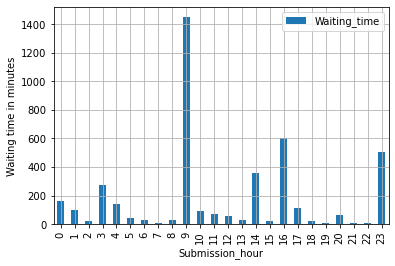

In [32]:
pd.DataFrame({'Submission_hour': target_jobs['Submission_date'].dt.hour,
              'Waiting_time': target_jobs['Waited']
             }).groupby('Submission_hour').quantile(0.95).plot.bar()
plt.ylabel('Waiting time in minutes'); plt.grid()

# [.....]

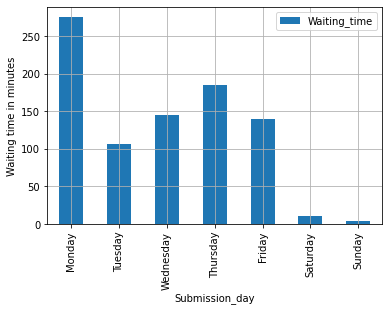

In [33]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pd.DataFrame({'Submission_day': target_jobs['Submission_date'].dt.day_name(),
              'Waiting_time': target_jobs['Waited']
             }).groupby('Submission_day').mean().reindex(cats).plot.bar()
plt.ylabel('Waiting time in minutes'); plt.grid()

# [.....]

#### Jobs that were both waiting and running

Text(0.5, 0, 'Waiting time in minutes')

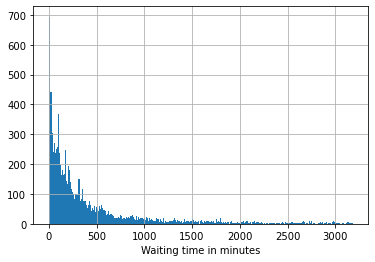

In [34]:
target_jobs = job_chars[queued_and_processed_jobs]
target_jobs['Waited'].hist(bins=np.arange(-2.5,target_jobs['Waited'].quantile(0.95),5))
plt.xlabel('Waiting time in minutes')

Waiting times are largest in the cllong batch class, followed by clmedium. XXXXXX

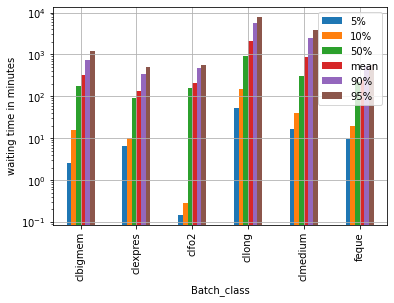

In [56]:
target_jobs = job_chars[queued_and_processed_jobs]
pd.DataFrame({
    '5%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.05),
    '10%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.10),
    '50%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.50),
    'mean': target_jobs.groupby('Batch_class')['Waited'].mean(),
    '90%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.90),
    '95%': target_jobs.groupby('Batch_class')['Waited'].quantile(0.95),
             }).plot.bar()
plt.yscale('log');
plt.ylabel('waiting time in minutes'); plt.grid()

Both the longest and least waiting times occur during business hours...

In [98]:
target_jobs = job_chars[queued_and_processed_jobs]

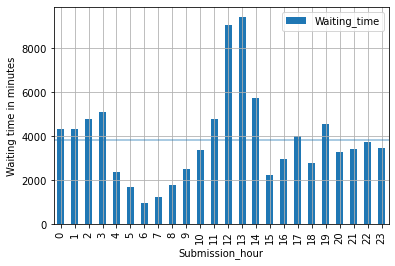

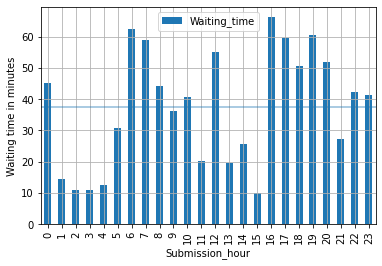

In [103]:
target_quantity = pd.DataFrame({
    'Submission_hour': target_jobs['Submission_date'].dt.hour,
    'Waiting_time': target_jobs['Waited']
             }).groupby('Submission_hour').quantile(0.95)

ax = target_quantity.plot.bar()
ax.axhline(y=target_quantity.mean().to_numpy(), color='tab:blue', alpha=0.5)
plt.ylabel('Waiting time in minutes'); plt.grid()

target_quantity = pd.DataFrame({
    'Submission_hour': target_jobs['Submission_date'].dt.hour,
    'Waiting_time': target_jobs['Waited']
             }).groupby('Submission_hour').quantile(0.10)

ax = target_quantity.plot.bar()
ax.axhline(y=target_quantity.mean().to_numpy(), color='tab:blue', alpha=0.5)
plt.ylabel('Waiting time in minutes'); plt.grid()

# [.....]

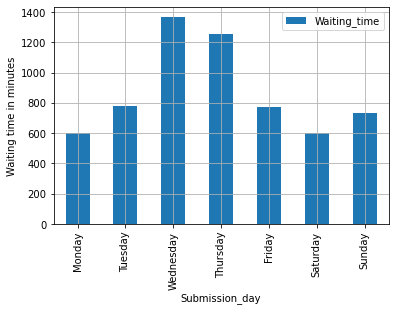

In [101]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pd.DataFrame({'Submission_day': target_jobs['Submission_date'].dt.day_name(),
              'Waiting_time': target_jobs['Waited']
             }).groupby('Submission_day').mean().reindex(cats).plot.bar()
plt.ylabel('Waiting time in minutes'); plt.grid()

# [.....]

Not clear why large waiting times decrease for an increasing number of jobs/nodes (and hence total resources) per job. Not clear why minimum waiting times increase towards the maximum located at three nodes, and for larger node numbers decrease again. There doesn't seem to be causal relationship here... explanation of this would need further investigation.

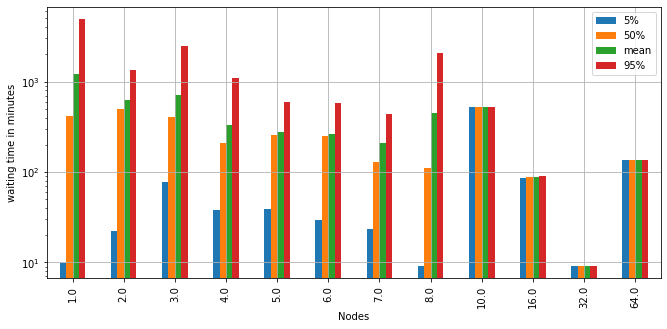

In [63]:
target_jobs = job_chars[queued_and_processed_jobs]
pd.DataFrame({
    '5%': target_jobs.groupby('Nodes')['Waited'].quantile(0.05),
    '50%': target_jobs.groupby('Nodes')['Waited'].quantile(0.50),
    'mean': target_jobs.groupby('Nodes')['Waited'].mean(),
    '95%': target_jobs.groupby('Nodes')['Waited'].quantile(0.95),
             }).plot.bar(figsize=(11,5))
plt.yscale('log');
plt.ylabel('waiting time in minutes'); plt.grid()

In [75]:
target_jobs = job_chars[queued_and_processed_jobs]

### Are waiting characteristics of undetected processing time jobs and very short lived duration jobs the same?
We might deduce sth. about the undetected processing time jobs here.

# OLD STUFF

### Jobs that have never been processed

In [ ]:
job_chars

### Jobs that never ran

In [77]:
subset = job_chars['Duration'].isna()

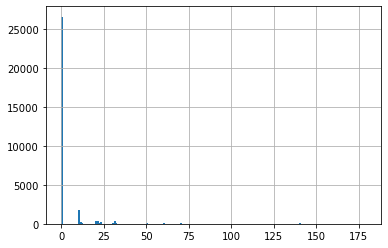

In [89]:
job_chars['Waited'][subset].hist(bins=np.arange(0,180,1))

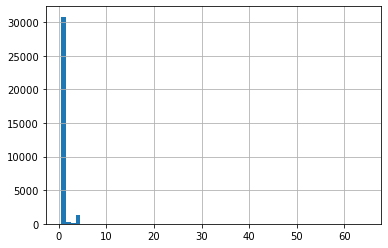

In [97]:
job_chars['Nodes'][subset].hist(bins=np.arange(0.5,64.9,1))

In [98]:
job_chars['Queue'][subset].value_counts()/subset.sum()*100

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[clmedium]    88.021121
[feque]        8.737030
[clexpres]     2.185792
[cllong]       0.653896
[clbigmem]     0.285504
[clfo2]        0.116657
Name: Queue, dtype: float64

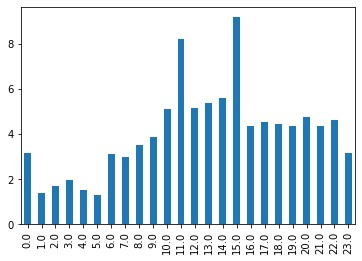

In [105]:
(job_chars['Submission'][subset].dt.hour.value_counts().sort_index()/subset.sum()*100).plot.bar()

### Jobs that never waited

In [112]:
subset = job_chars['Waited'].isna()

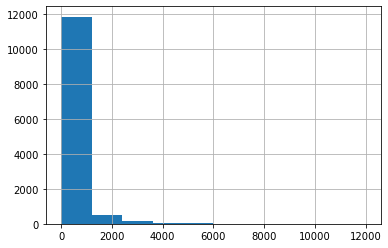

In [114]:
job_chars['Duration'][subset].hist()

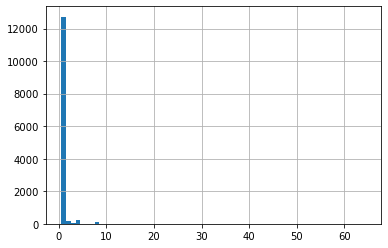

In [115]:
job_chars['Nodes'][subset].hist(bins=np.arange(0.5,64.9,1))

In [116]:
job_chars['Queue'][subset].value_counts()/subset.sum()*100

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[clmedium]    60.368871
[feque]       16.216824
[clfo2]       10.893687
[clexpres]     5.330634
[cllong]       4.430949
[clbigmem]     2.759034
Name: Queue, dtype: float64

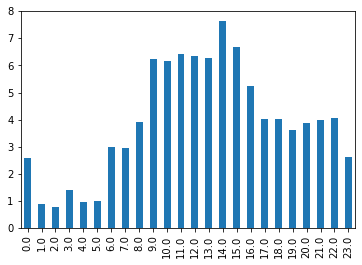

In [119]:
(job_chars['Start'][subset].dt.hour.value_counts().sort_index()/subset.sum()*100).plot.bar()

### Jobs that both waited and ran

In [121]:
subset = job_chars['Waited'].notna() & job_chars['Duration'].notna()

In [123]:
job_chars['Queue'][subset].value_counts()/subset.sum()*100

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[clmedium]    69.303155
[feque]       12.147119
[cllong]       9.090350
[clexpres]     5.012608
[clbigmem]     2.349468
[clfo2]        2.097300
Name: Queue, dtype: float64

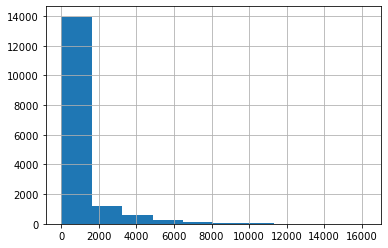

In [125]:
job_chars['Waited'][subset].hist()

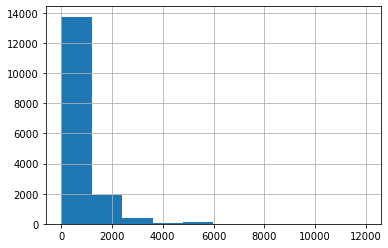

In [126]:
job_chars['Duration'][subset].hist()

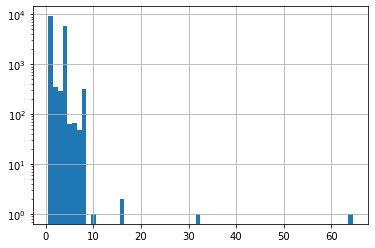

In [145]:
job_chars['Nodes'][subset].hist(bins=np.arange(0.5,64.9,1))

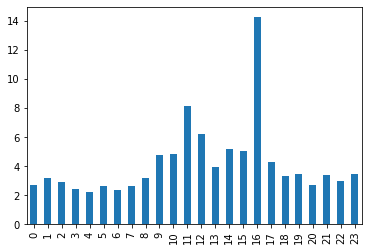

In [128]:
(job_chars['Submission'][subset].dt.hour.value_counts().sort_index()/subset.sum()*100).plot.bar()

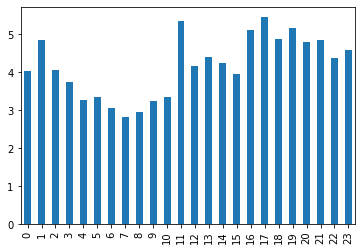

In [129]:
(job_chars['Start'][subset].dt.hour.value_counts().sort_index()/subset.sum()*100).plot.bar()

## Linux cluster statistics

Text(0.5, 0, 'Job waiting time in hours')

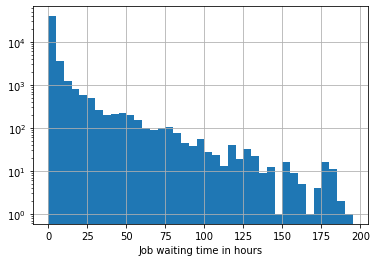

In [144]:
(job_chars['Waited']/60).hist(bins=np.arange(0,200,5))
plt.yscale("log")
plt.xlabel('Job waiting time in hours')

Text(0.5, 0, 'Job duration in hours')

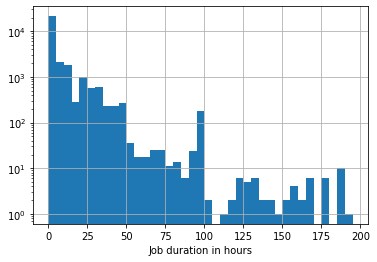

In [143]:
(job_chars['Duration']/60).hist(bins=np.arange(0,200,5))
plt.yscale("log")
plt.xlabel('Job duration in hours')

Text(0.5, 0, 'CPU average occupancy per job')

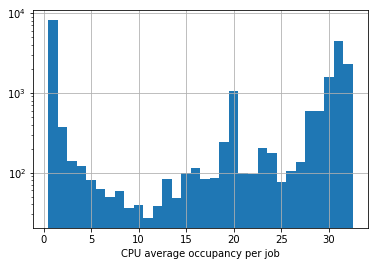

In [142]:
job_chars['CPUs'].hist(bins=np.arange(0.5,33.5,1))
plt.yscale("log")
plt.xlabel('CPU average occupancy per job')

Text(0.5, 0, 'Maximum memory per job in GB')

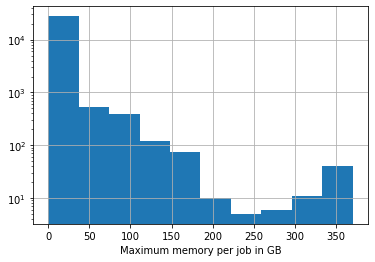

In [141]:
job_chars['Memory'].hist()
plt.yscale("log")
plt.xlabel('Maximum memory per job in GB')

64.0


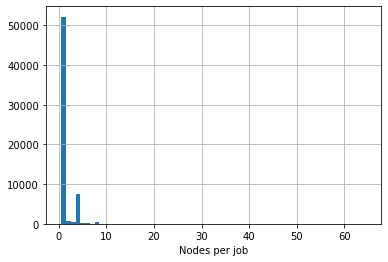

In [146]:
job_chars['Nodes'].hist(bins=np.arange(0.5,65,1))
#plt.yscale("log")
plt.xlabel('Nodes per job')
print(job_chars['Nodes'].max())

## Queue statistics

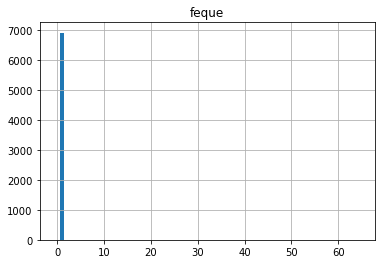

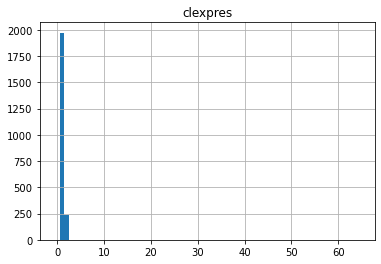

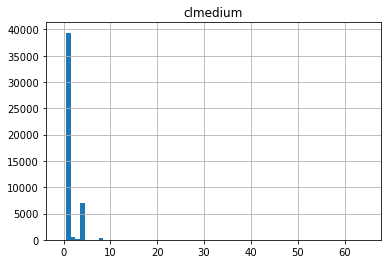

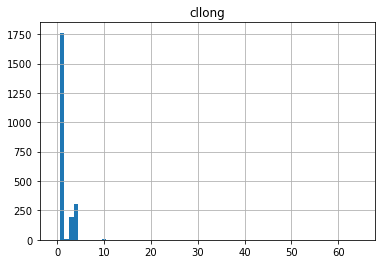

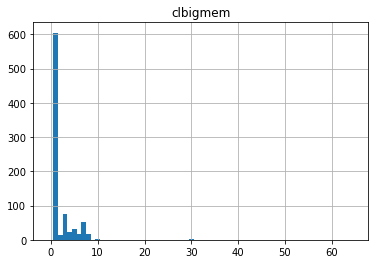

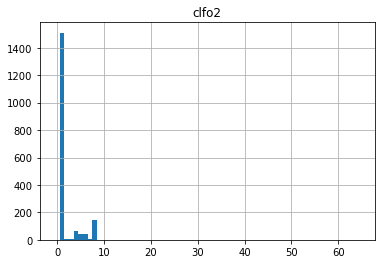

In [66]:
these_queues = ["feque", "clexpres", "clmedium", "cllong", "clbigmem", "clfo2"]

for this_queue in these_queues:
    plt.figure(); plt.title(this_queue)
    job_chars["Jobs"].where(job_chars["Queue"]==this_queue).hist(bins=np.arange(-0.5,65,1))

## Single vs. multi-node jobs